In [5]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

"""
    Linear regression using the Ridge method
"""

def RidgeRegression(x, y, z, degree=5, l=0.0001):
    """
    :param x: numpy vector of size (n, 1)
    :param y: numpy vector of size (n, 1)
    :param degree: degree of polynomial fit
    :param l: Ridge penalty coefficient
    :return: numpy array with the beta coefficients
    """
    # Calculate matrix with x, y - polynomials
    M_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    M = poly.fit_transform(M_)



    # Calculate beta
    A = np.arange(1, degree + 2)
    rows = np.sum(A)
    beta = (np.linalg.inv(M.T.dot(M) + l * np.identity(rows))).dot(M.T).dot(z)

    return beta


In [6]:
"""
Functions to use in analysis of a regression method
"""

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def FrankeFunction(x,y, noise=0.01):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return (term1 + term2 + term3 + term4 + noise*np.random.randn(len(x)))

def R2(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: R2-score
    """
    meanValue = np.mean(zReal)
    numerator = np.sum((zReal - zPredicted)**2)
    denominator = np.sum((zReal - meanValue)**2)
    result = 1 - (numerator/denominator)
    return result

def MeanSquaredError(z, z_hat):
    """
    :param z: actual z-values, size (n, 1)
    :param z_hat: predicted z-values, size (n, 1)
    :return: Mean squared error
    """
    MSE = np.sum((z - z_hat)**2)/len(z)
    return MSE

def betaConfidenceInterval_Ridge(z_real, beta, X, l):
    """
    Compute a 90% confidence interval for the beta coefficients - Ridge
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma_2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    XTX= X.T.dot(X)
    R, R = np.shape(XTX)
    var_beta = np.diag(sigma_2*np.linalg.inv((XTX + l*np.identity(R))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    i_minus = beta - 1.645*np.sqrt(var_beta/N)
    i_plus = beta + 1.645*np.sqrt(var_beta/N)

    return i_minus, i_plus

def betaConfidenceInterval_OLS(z_real, beta, X):
    """
    Compute a 90% confidence interval for the beta coefficients
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma_2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    var_beta = np.diag(sigma_2*np.linalg.inv((X.T.dot(X))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    i_minus = beta - 1.645*np.sqrt(var_beta/N)
    i_plus = beta + 1.645*np.sqrt(var_beta/N)

    return i_minus, i_plus

def plotFrankes(beta, degree=5):
    """
    Plot Franke's function
    """

    x = np.arange(0, 1, 0.01)
    y = np.arange(0, 1, 0.01)

    x_, y_ = np.meshgrid(x, y)
    x = x_.reshape(-1,1)
    y = y_.reshape(-1,1)

    M = np.c_[x, y]
    poly = PolynomialFeatures(degree=degree)
    M_ = poly.fit_transform(M)
    predict = M_.dot(beta)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x_, y_, predict.reshape(100, 100), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.show()

In [7]:
from sklearn.utils import resample
def bootstrap(x, y, z, p_degree, method, n_bootstrap=100):
    # Randomly shuffle data
    data_set = np.c_[x, y, z]
    np.random.shuffle(data_set)
    set_size = round(len(x)/5)

    # Extract test-set, never used in training. About 1/5 of total data
    x_test = data_set[0:set_size, 0]
    y_test = data_set[0:set_size, 1]
    z_test = data_set[0:set_size, 2]
    test_indices = np.linspace(0, set_size-1, set_size)

    # And define the training set as the rest of the data
    x_train = np.delete(data_set[:, 0], test_indices)
    y_train = np.delete(data_set[:, 1], test_indices)
    z_train = np.delete(data_set[:, 2], test_indices)

    Z_predict = []

    MSE = []
    R2s = []
    for i in range(n_bootstrap):
        x_, y_, z_ = resample(x_train, y_train, z_train)

        if method == 'Ridge':
            # Ridge regression, save beta values
            beta = RidgeRegression(x_, y_, z_, degree=p_degree)
        elif method == 'Lasso':
            beta = Lasso(x_, y_, z_, degree=p_degree)
        elif method == 'OLS':
            beta = ols(x_, y_, z_, degree=p_degree)
        else:
            print('ERROR: Cannot recognize method')
            return 0

        M_ = np.c_[x_test, y_test]
        poly = PolynomialFeatures(p_degree)
        M = poly.fit_transform(M_)
        z_hat = M.dot(beta)

        Z_predict.append(z_hat)

        # Calculate MSE
        MSE.append(np.mean((z_test - z_hat)**2))
        R2s.append(R2(z_test, z_hat))
        print('Round: ', i)

    # Calculate MSE, Bias and Variance
    MSE_M = np.mean(MSE)
    R2_M = np.mean(R2s)
    bias = np.mean((z_test - np.mean(Z_predict, axis=0, keepdims=True))**2)
    variance = np.mean(np.var(Z_predict, axis=0, keepdims=True))
    return MSE_M, R2_M, bias, variance

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import numpy as np

def Lasso(x, y, z, degree=5, a=1e-06):

    X = np.c_[x, y]
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    clf = linear_model.Lasso(alpha=a, max_iter=5000, fit_intercept=False)
    clf.fit(X_, z)
    beta = clf.coef_

    return beta

In [9]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

In [10]:
"""
    Analysis of a Lasso Regression model of Franke's function, using set of 1000 random x and y points
"""

# Load random data, 1000 points
X = np.load('data.npy')
x = X[:, 0]
y = X[:, 1]

In [11]:
############################################
#   Investigate difference alphas          #
############################################
alphas = [10**-10, 10**-9, 10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3]
alpha_logs = [-10, -9, -8, -7, -6, -5, -4, -3]

z = FrankeFunction(x, y, noise=0)

In [12]:
Bs = []
for al in alphas:
    Bs.append(Lasso(x, y, z, degree=5, a=al))

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7953565091332138, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.795351971632455, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.795306377636899, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

In [13]:
# Generate new test data
x_test = np.random.rand(200)
y_test = np.random.rand(200)
z_test = FrankeFunction(x_test, y_test, noise=0)

In [14]:
M_ = np.c_[x_test, y_test]
poly = PolynomialFeatures(5)
M = poly.fit_transform(M_)
MSEs = []
R2s = []
for i in range(len(alphas)):
    z_predict = M.dot(Bs[i])
    MSE = MeanSquaredError(z_test, z_predict)
    MSEs.append(MSE)
    R2_score = R2(z_test, z_predict)
    R2s.append(R2_score)
    print('--- Alpha value: {0} ---\n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(alphas[i], MSE, R2_score))

--- Alpha value: 1e-10 ---
 Mean Squared error: 0.0059394 
 R2 Score: 0.9251813

--- Alpha value: 1e-09 ---
 Mean Squared error: 0.0059394 
 R2 Score: 0.9251811

--- Alpha value: 1e-08 ---
 Mean Squared error: 0.0059395 
 R2 Score: 0.9251795

--- Alpha value: 1e-07 ---
 Mean Squared error: 0.0059408 
 R2 Score: 0.9251635

--- Alpha value: 1e-06 ---
 Mean Squared error: 0.0059528 
 R2 Score: 0.9250115

--- Alpha value: 1e-05 ---
 Mean Squared error: 0.0060330 
 R2 Score: 0.9240012

--- Alpha value: 0.0001 ---
 Mean Squared error: 0.0083819 
 R2 Score: 0.8944119

--- Alpha value: 0.001 ---
 Mean Squared error: 0.0142714 
 R2 Score: 0.8202216



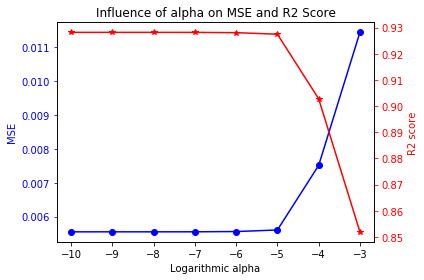

In [30]:
import seaborn as sns
fig, ax1 = plt.subplots()
ax1.plot(alpha_logs, MSEs, 'bo-')
ax1.set_xlabel('Logarithmic alpha')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('MSE', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(alpha_logs, R2s, 'r*-')
ax2.set_ylabel('R2 score', color='r')
ax2.tick_params('y', colors='r')

plt.title('Influence of alpha on MSE and R2 Score')
fig.tight_layout()
plt.show()

In [25]:
# Investigate how the alpha values are influenced by noise
noise = np.arange(0, 0.4, 0.01)
alphas = [10**-7, 10**-6, 10**-5, 10**-4]
Bs = []

# Generate more data to test
x_test = np.random.rand(200)
y_test = np.random.rand(200)
M_ = np.c_[x_test, y_test]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

for al in alphas:
    B = []
    print(al)
    for n in noise:
        z = FrankeFunction(x, y, noise=n)
        B.append(Lasso(x, y, z, degree=5, a=al))
    Bs.append(B)

1e-07


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.794828107904277, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7968979885918457, tolerance: 0.025188852026155895
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.04773087554938, tolerance: 0.02533077469147503
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.277121708536335, tolerance: 0.034776972521910955
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.35636971147092, tolerance: 0.036480694110499756
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.66319269066024, tolerance: 0.03443282952056539
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

1e-06


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1963662488927014, tolerance: 0.0252925710781424
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.753816020763504, tolerance: 0.02533725291448019
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.070511775997377, tolerance: 0.025515101651451107
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.81745793509303, tolerance: 0.038317935269787995
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.40488334325096, tolerance: 0.03740236504822115
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.42146800331147, tolerance: 0.038730503657988656
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

1e-05


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5624878546300462, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.623712393520925, tolerance: 0.025202821507490675
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7540246846038885, tolerance: 0.025142020066821022
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.45360558154614, tolerance: 0.03700591934126739
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.44811326073994, tolerance: 0.03531513997383175
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.59214079430926, tolerance: 0.036995199021890544
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

0.0001


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07979362850227201, tolerance: 0.025302599871935373
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07886781803453857, tolerance: 0.02537456471437198
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07231628962148129, tolerance: 0.025394465710539382
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11416985287510784, tolerance: 0.04008052415188748
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.310415807430388, tolerance: 0.039206203416955604
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1849482187881506, tolerance: 0.0381615563843268
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

--- lambda value: 1e-07 --
 Noise: 0.0 
 Mean Squared error: 0.0054911 
 R2 Score: 0.9317694

 Noise: 0.01 
 Mean Squared error: 0.0055473 
 R2 Score: 0.9310443

 Noise: 0.02 
 Mean Squared error: 0.0057323 
 R2 Score: 0.9297153

 Noise: 0.03 
 Mean Squared error: 0.0068010 
 R2 Score: 0.9172609

 Noise: 0.04 
 Mean Squared error: 0.0069927 
 R2 Score: 0.9179629

 Noise: 0.05 
 Mean Squared error: 0.0077172 
 R2 Score: 0.9069309

 Noise: 0.06 
 Mean Squared error: 0.0075033 
 R2 Score: 0.9087333

 Noise: 0.07 
 Mean Squared error: 0.0104912 
 R2 Score: 0.8759259

 Noise: 0.08 
 Mean Squared error: 0.0124054 
 R2 Score: 0.8591498

 Noise: 0.09 
 Mean Squared error: 0.0134933 
 R2 Score: 0.8446688

 Noise: 0.1 
 Mean Squared error: 0.0133318 
 R2 Score: 0.8490082

 Noise: 0.11 
 Mean Squared error: 0.0182799 
 R2 Score: 0.7858603

 Noise: 0.12 
 Mean Squared error: 0.0225982 
 R2 Score: 0.7607288

 Noise: 0.13 
 Mean Squared error: 0.0196786 
 R2 Score: 0.7906378

 Noise: 0.14 
 Mean Squ

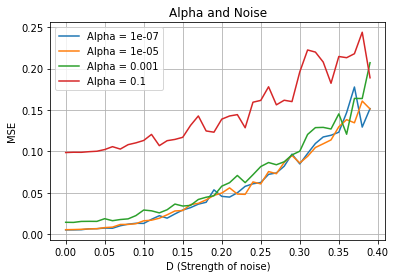

In [33]:
lines = []
plt.figure()
for i in range(len(alphas)):
    print('--- lambda value:', alphas[i], '--')
    line = []
    for j in range(len(noise)):
        z_test = FrankeFunction(x_test, y_test, noise=noise[j])
        z_predict = M.dot(Bs[i][j])
        MSE = MeanSquaredError(z_test, z_predict)
        line.append(MSE)
        R2_score = R2(z_test, z_predict)
        print(' Noise: {0} \n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(noise[j], MSE, R2_score))
    plt.plot(noise, line, label='Alpha = {0}'.format(alphas[i]))

plt.legend()
plt.xlabel('D (Strength of noise)')
plt.ylabel('MSE')
plt.grid(True)
plt.title('Alpha and Noise')
plt.show()

In [27]:
# Evaluate model with bootstrap
X = np.load('data.npy')
x = X[:, 0]
y = X[:, 1]
z = FrankeFunction(x, y, noise=0.1)

MSE, R2_b, bias, variance = bootstrap(x, y, z, method='Lasso', p_degree=5)
print('--- BOOTSTRAP ---')
print('MSE: ', MSE)
print('R2: ', R2_b)
print('Bias: ', bias)
print('Variance: ', variance)

C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  from ipykernel import kernelapp as app
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()
C:\Users\bod\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.866378820294683, tolerance: 0.02011680965411039
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

Round:  0
Round:  1
Round:  2
Round:  3


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.974581487428365, tolerance: 0.019751263412410045
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.2645939633401255, tolerance: 0.02201204437634134
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.776754558307411, tolerance: 0.019885258263606823
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Round:  4
Round:  5
Round:  6
Round:  7


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.895626354525428, tolerance: 0.0198965217128133
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.565503534750729, tolerance: 0.021242507574506943
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3570870807869415, tolerance: 0.02182645500562925
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  8
Round:  9
Round:  10
Round:  11


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.738025034765085, tolerance: 0.021251129932030318
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.86893222097078, tolerance: 0.022788564765480687
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.995161261605514, tolerance: 0.02095964910683684
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  12
Round:  13
Round:  14
Round:  15


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.500328840473692, tolerance: 0.021179973017154324
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.893439269288541, tolerance: 0.020581247127794983
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.970721770454564, tolerance: 0.020399757044100165
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Round:  16
Round:  17
Round:  18
Round:  19


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.020837789909295, tolerance: 0.0208074555659073
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.931709480597525, tolerance: 0.02018046514825822
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.086135766479909, tolerance: 0.020633603711055434
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Round:  20
Round:  21
Round:  22
Round:  23


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.549695545003371, tolerance: 0.018719615333009386
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.80457230600533, tolerance: 0.020378782195822783
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.059381626711832, tolerance: 0.022623035568878423
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Round:  24
Round:  25
Round:  26
Round:  27


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.655756702512142, tolerance: 0.021285036427709396
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.873006190168381, tolerance: 0.020735360048172335
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.269881161343254, tolerance: 0.021388201534818012
  positive)


Round:  28
Round:  29
Round:  30
Round:  31


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0563504995538935, tolerance: 0.020888524180085154
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4452188847525, tolerance: 0.021061235429870467
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.819701610151112, tolerance: 0.021227095003120925
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Round:  32
Round:  33
Round:  34
Round:  35


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.054207279608106, tolerance: 0.02067999014106577
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.549669068546065, tolerance: 0.020860618851660757
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.014688220856226, tolerance: 0.02141012196604837
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  36
Round:  37
Round:  38
Round:  39


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.837038462814951, tolerance: 0.021162594612571577
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.611900601927386, tolerance: 0.0218442274635338
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.773389612271735, tolerance: 0.02016932333767272
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Round:  40
Round:  41
Round:  42
Round:  43


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.617284143611496, tolerance: 0.021083980974860278
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.131805358815548, tolerance: 0.021282983342155126
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.19363587688694, tolerance: 0.021117395472747127
  positive)


Round:  44
Round:  45
Round:  46
Round:  47


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.744132072543463, tolerance: 0.020839992694879548
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.915567662891759, tolerance: 0.02107274696317419
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.390033698543479, tolerance: 0.020878428792612258
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Round:  48
Round:  49
Round:  50
Round:  51


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.000037380012151, tolerance: 0.02175847439358919
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.57455963121424, tolerance: 0.020124721094599073
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.666254245614904, tolerance: 0.02004255454272204
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Round:  52
Round:  53
Round:  54
Round:  55


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.970255252494188, tolerance: 0.020134285207042742
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.066225518056114, tolerance: 0.01923182048435388
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.779323458524794, tolerance: 0.02007896990971514
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  56
Round:  57
Round:  58
Round:  59


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.620130769899454, tolerance: 0.020404573130374033
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4734404643534535, tolerance: 0.02019653635106722
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.958542762476573, tolerance: 0.021332771627651632
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Round:  60
Round:  61
Round:  62
Round:  63


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.875319427354669, tolerance: 0.02185750954126752
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.870334617078885, tolerance: 0.02158680227814381
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.950730239995811, tolerance: 0.021317285233667903
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  64
Round:  65
Round:  66


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.690113050993183, tolerance: 0.021063995469170774
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.073043957425153, tolerance: 0.020980600311235012
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.2245640013720935, tolerance: 0.019881490987816542
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

Round:  67
Round:  68
Round:  69
Round:  70


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9323156998164555, tolerance: 0.021658109782268023
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.608912885604326, tolerance: 0.020323877812882307
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.659905405159619, tolerance: 0.02243841042823571
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Round:  71
Round:  72
Round:  73
Round:  74


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.85695946247043, tolerance: 0.0222647096981696
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.002692594080945, tolerance: 0.021472992644093025
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.728857186475976, tolerance: 0.02021279470133672
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Round:  75
Round:  76
Round:  77
Round:  78


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.702360633239587, tolerance: 0.020658097376052512
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.038313697959205, tolerance: 0.021915351936500512
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.951405242467004, tolerance: 0.019797018586489152
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Round:  79
Round:  80
Round:  81
Round:  82


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.814900088157567, tolerance: 0.018435745581504518
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.103645698275261, tolerance: 0.022002906083842297
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.464295048614253, tolerance: 0.020708473560172354
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Round:  83
Round:  84
Round:  85
Round:  86


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.134040011363739, tolerance: 0.023083193010191568
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.79748566855931, tolerance: 0.021280085224547635
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.190283374384262, tolerance: 0.02233418795354308
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  87
Round:  88
Round:  89
Round:  90


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.911949267645979, tolerance: 0.021278050270892017
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0424560770843065, tolerance: 0.020180546519462262
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.901620351091257, tolerance: 0.020060818894492485
  positive)


Round:  91
Round:  92
Round:  93
Round:  94


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.287840497494997, tolerance: 0.020673370086762767
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.967445229020031, tolerance: 0.0212259120250305
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.448136131129236, tolerance: 0.021759586347320125
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  95
Round:  96
Round:  97
Round:  98
Round:  99
--- BOOTSTRAP ---
MSE:  0.01841376961432764
R2:  0.8006827768702576
Bias:  0.018130611456799936
Variance:  0.00028315815752770934


In [3]:
"""
Functions to use in analysis of a regression method
"""
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.utils import resample
from sklearn import linear_model

def FrankeFunction(x,y, noise = 0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return (term1 + term2 + term3 + term4 + noise*np.random.randn(len(x)))


def R2(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: R2-score
    """
    meanValue = np.mean(zReal)
    numerator = np.sum((zReal - zPredicted)**2)
    denominator = np.sum((zReal - meanValue)**2)
    result = 1 - (numerator/denominator)
    return result

def MeanSquaredError(z, z_hat):
    """
    :param z: actual z-values, size (n, 1)
    :param z_hat: predicted z-values, size (n, 1)
    :return: Mean squared error
    """
    MSE = np.sum((z - z_hat)**2)/len(z)
    return MSE

def betaCI_OLS(z_real, beta, X):
    """
    Compute a 90% confidence interval for the beta coefficients
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    var_beta = np.diag(sigma2*np.linalg.inv((X.T.dot(X))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    ci_minus = beta - 1.645*np.sqrt(var_beta/N)
    ci_plus = beta + 1.645*np.sqrt(var_beta/N)

    return ci_minus, ci_plus


def betaCI_Ridge(z_real, beta, X, l):
    """
    Compute a 90% confidence interval for the beta coefficients - Ridge
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma_2 = (np.sum(np.power((z_real-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    XTX= X.T.dot(X)
    R, R = np.shape(XTX)
    var_beta = np.diag(sigma_2*np.linalg.inv((XTX + l*np.identity(R))))

    # The square root of var_beta is the standard error. Use it to calculate confidence intervals
    ci_minus = beta - 1.645*np.sqrt(var_beta/N)
    ci_plus = beta + 1.645*np.sqrt(var_beta/N)

    return ci_minus, ci_plus

def plotFrankes(x_, y_, z_):
    """
    Plot Franke's function
    """

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x_, y_, z_, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z - Franke')

    # Add a color bar which maps values to colors.
    clb = fig.colorbar(surf, shrink=0.5, aspect=5)
    clb.ax.set_title('Level')

    plt.savefig('./Figure/Franke.pdf')

#Ordinary Least Squared function
def ols(x, y, z, degree = 5):
    #x: vector of size(n, 1)
    #y: vector of size(n,1)
    #z: vector of size(n,1)
    xyb_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    xyb = poly.fit_transform(xyb_)
    beta = np.linalg.inv(xyb.T.dot(xyb)).dot(xyb.T).dot(z)

    return beta

def RidgeRegression(x, y, z, degree=5, l=0.0001):
    """
    :param x: numpy vector of size (n, 1)
    :param y: numpy vector of size (n, 1)
    :param degree: degree of polynomial fit
    :param l: Ridge penalty coefficient
    :return: numpy array with the beta coefficients
    """
    # Calculate matrix with x, y - polynomials
    M_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    M = poly.fit_transform(M_)

    # Calculate beta
    A = np.arange(1, degree + 2)
    rows = np.sum(A)
    beta = (np.linalg.inv(M.T.dot(M) + l * np.identity(rows))).dot(M.T).dot(z)

    return beta

def bootstrap(x, y, z, p_degree, method, n_bootstrap=100):
    # Randomly shuffle data
    data_set = np.c_[x, y, z]
    np.random.shuffle(data_set)
    set_size = round(len(x)/5)

    # Extract test-set, never used in training. About 1/5 of total data
    x_test = data_set[0:set_size, 0]
    y_test = data_set[0:set_size, 1]
    z_test = data_set[0:set_size, 2]
    test_indices = np.linspace(0, set_size-1, set_size)

    # And define the training set as the rest of the data
    x_train = np.delete(data_set[:, 0], test_indices)
    y_train = np.delete(data_set[:, 1], test_indices)
    z_train = np.delete(data_set[:, 2], test_indices)

    Z_predict = []

    MSE = []
    R2s = []
    for i in range(n_bootstrap):
        x_, y_, z_ = resample(x_train, y_train, z_train)

        if method == 'Ridge':
            # Ridge regression, save beta values
            beta = RidgeRegression(x_, y_, z_, degree=p_degree)
        elif method == 'Lasso':
            beta = Lasso(x_, y_, z_, degree=p_degree)
        elif method == 'OLS':
            beta = ols(x_, y_, z_, degree=p_degree)
        else:
            print('ERROR: Cannot recognize method')
            return 0

        M_ = np.c_[x_test, y_test]
        poly = PolynomialFeatures(p_degree)
        M = poly.fit_transform(M_)
        z_hat = M.dot(beta)

        Z_predict.append(z_hat)

        # Calculate MSE
        MSE.append(np.mean((z_test - z_hat)**2))
        R2s.append(R2(z_test, z_hat))
        print('Round: ', i)

    # Calculate MSE, Bias and Variance
    MSE_M = np.mean(MSE)
    R2_M = np.mean(R2s)
    bias = np.mean((z_test - np.mean(Z_predict, axis=0, keepdims=True))**2)
    variance = np.mean(np.var(Z_predict, axis=0, keepdims=True))
    return MSE_M, R2_M, bias, variance

def Lasso(x, y, z, degree=5, a=1e-06):

    X = np.c_[x, y]
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    clf = linear_model.Lasso(alpha=a, max_iter=5000, fit_intercept=False)
    clf.fit(X_, z)
    beta = clf.coef_

    return beta


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7953565091332138, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.795351971632455, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.795306377636899, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.65223675743975, tolerance: 0.03275305428638094
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.703128693600135, tolerance: 0.0318902465332386
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.81883626252812, tolerance: 0.03322813206359079
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.889738477167047, tolerance: 0.028723519021282243
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.129843997016643, tolerance: 0.02813513200583402
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.493709398416343, tolerance: 0.029471205778587216
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

Round:  0
Round:  1
Round:  2
Round:  3


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.82575083775404, tolerance: 0.03244987777545412
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.91426801605976, tolerance: 0.03270847751455166
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.07643989420966, tolerance: 0.033917543538729285
  positive)


Round:  4
Round:  5
Round:  6
Round:  7


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.78902418603899, tolerance: 0.03477015179620925
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.6101064956967, tolerance: 0.032491780002967936
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.03171296943622, tolerance: 0.03427266180667729
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Round:  8
Round:  9
Round:  10
Round:  11


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.40904189105608, tolerance: 0.03637874835249627
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.5734449721728, tolerance: 0.035134522201106466
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.54036879288697, tolerance: 0.03231458661706493
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Round:  12
Round:  13
Round:  14
Round:  15


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.15095192058873, tolerance: 0.03143613925186179
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.988528105396206, tolerance: 0.03239221551439946
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.24851460734788, tolerance: 0.030148349715545
  positive)


Round:  16
Round:  17
Round:  18
Round:  19


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.11882364381582, tolerance: 0.03334360500971266
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.0617046539063, tolerance: 0.031883651750270345
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.23386147042524, tolerance: 0.030309955342737296
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  20
Round:  21
Round:  22
Round:  23


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.49758520730515, tolerance: 0.033003370744794494
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.31791032120535, tolerance: 0.030760174526854214
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.23034412110137, tolerance: 0.03416628964263607
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Round:  24
Round:  25
Round:  26
Round:  27


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.76192803062393, tolerance: 0.031233872682761184
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.51068295355799, tolerance: 0.03259568753883495
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.99412188246625, tolerance: 0.034132095020894204
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Round:  28
Round:  29
Round:  30
Round:  31


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.21446011635129, tolerance: 0.031512390404710086
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.53318212587213, tolerance: 0.03185322803309223
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.56877514247222, tolerance: 0.033266717182888816
  positive)


Round:  32
Round:  33
Round:  34


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.555318326758766, tolerance: 0.03204808124029659
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.73140613195247, tolerance: 0.033573681881921565
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.79022369160792, tolerance: 0.03237615272126259
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Round:  35
Round:  36
Round:  37
Round:  38


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.14148268475076, tolerance: 0.03194810337581229
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.34256466737357, tolerance: 0.03032792614372325
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.83324670821047, tolerance: 0.034160612282382874
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  39
Round:  40
Round:  41
Round:  42


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.88924145948302, tolerance: 0.032651261095844056
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.26802071051826, tolerance: 0.032201600604933725
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.76548911865099, tolerance: 0.03748863118898093
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Round:  43
Round:  44
Round:  45
Round:  46


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.42312002669016, tolerance: 0.03142985592089409
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.9465174598784, tolerance: 0.03424250268778713
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.38183350560293, tolerance: 0.032925923705829314
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Round:  47
Round:  48
Round:  49
Round:  50


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.9149874077988, tolerance: 0.03362393146094841
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.73660668850356, tolerance: 0.035236771130940155
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.30631664301612, tolerance: 0.03290409117356851
  positive)


Round:  51
Round:  52
Round:  53


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.7154947892259, tolerance: 0.03249453420821208
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.56987894925338, tolerance: 0.03298282887225112
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.85752876530796, tolerance: 0.03185023157824559
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Round:  54
Round:  55
Round:  56
Round:  57


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.26336077961112, tolerance: 0.036638259441577434
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.43819859714705, tolerance: 0.03463887960583355
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.416512280426005, tolerance: 0.03374441981883788
  positive)


Round:  58
Round:  59
Round:  60
Round:  61


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.71006611797662, tolerance: 0.032920442303437186
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.98463203427666, tolerance: 0.03452143541859889
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.88498350279756, tolerance: 0.03305283048758798
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  62
Round:  63
Round:  64
Round:  65


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.28833985513648, tolerance: 0.03390820282123474
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.35333630439445, tolerance: 0.032401139610483215
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.11605363709766, tolerance: 0.03371048385504363
  positive)


Round:  66
Round:  67
Round:  68
Round:  69


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.53895773013766, tolerance: 0.030294439741945907
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.31256066917557, tolerance: 0.03597751446532593
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.05843808184948, tolerance: 0.03205396418614814
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Round:  70
Round:  71
Round:  72
Round:  73


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.4547871406871, tolerance: 0.03236345369562833
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.37558701899291, tolerance: 0.0295032657710656
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.073837118734566, tolerance: 0.03339135049177181
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Round:  74
Round:  75
Round:  76
Round:  77


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.30225292111368, tolerance: 0.035609444283456415
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.781861636314076, tolerance: 0.032037087047816055
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.14934271929705, tolerance: 0.03572968169576901
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Round:  78
Round:  79
Round:  80
Round:  81


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.833439502172645, tolerance: 0.030439493293147383
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.628912815293134, tolerance: 0.033773281227451483
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.78726552377931, tolerance: 0.029708131906235714
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

Round:  82
Round:  83
Round:  84
Round:  85


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.25903312798037, tolerance: 0.03293275083603952
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.235301240063556, tolerance: 0.032213177042467275
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.5679507928699, tolerance: 0.0342097715022255
  positive)


Round:  86
Round:  87
Round:  88
Round:  89


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.24053657995612, tolerance: 0.03190021896883603
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.17194439298878, tolerance: 0.03438074870896703
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.16901187969138, tolerance: 0.03259993262027753
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Round:  90
Round:  91
Round:  92
Round:  93


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.91823967716199, tolerance: 0.03260843758136298
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.3881168704658, tolerance: 0.0323753053900556
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.21839088298209, tolerance: 0.03252692335748773
  positive)


Round:  94
Round:  95
Round:  96
Round:  97


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.22943739710726, tolerance: 0.034739933743490416
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.05009469389501, tolerance: 0.03059384806177718
  positive)


Round:  98
Round:  99


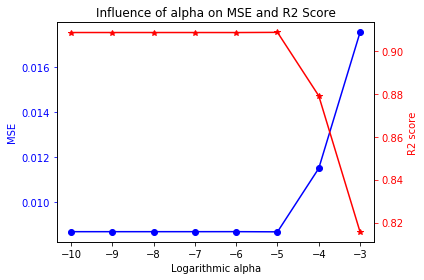

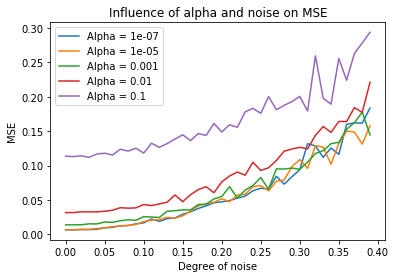

In [35]:
from AnalysisFunctions import *
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

"""
    Analysis of a Lasso Regression model of Franke's function
"""

# Load data
X = np.load('data.npy')
x = X[:, 0]
y = X[:, 1]
z = FrankeFunction(x, y)

alphas = [10**-10, 10**-9, 10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3]
alpha_logs = [-10, -9, -8, -7, -6, -5, -4, -3]

Bs = []
for al in alphas:
    Bs.append(Lasso(x, y, z, degree=5, a=al))

# Generate new test data
x_test = np.random.rand(200)
y_test = np.random.rand(200)
z_test = FrankeFunction(x_test, y_test)

M_ = np.c_[x_test, y_test]
poly = PolynomialFeatures(5)
M = poly.fit_transform(M_)
MSEs = []
R2s = []
text_file = open("./Results/Bootstrap_lasso.txt", "w")
for i in range(len(alphas)):
    z_predict = M.dot(Bs[i])
    MSE = MeanSquaredError(z_test, z_predict)
    MSEs.append(MSE)
    R2_score = R2(z_test, z_predict)
    R2s.append(R2_score)
    text_file.write('--- Alpha value: {0} ---\n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(alphas[i], MSE, R2_score))

# make plot
fig, ax1 = plt.subplots()
ax1.plot(alpha_logs, MSEs, 'bo-')
ax1.set_xlabel('Logarithmic alpha')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('MSE', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(alpha_logs, R2s, 'r*-')
ax2.set_ylabel('R2 score', color='r')
ax2.tick_params('y', colors='r')

plt.title('Influence of alpha on MSE and R2 Score')
fig.tight_layout()
plt.savefig('./Results/MSE_R2_alpha.pdf')

# Investigate how the alpha values are influenced by noise
noise = np.arange(0, 0.4, 0.01)
alphas = [10**-7, 10**-5, 10**-3,10**-2, 10**-1]
Bs = []

# Generate more data to test
x_test = np.random.rand(200)
y_test = np.random.rand(200)
M_ = np.c_[x_test, y_test]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

for al in alphas:
    B = []
    #print(al)
    for n in noise:
        z = FrankeFunction(x, y, noise=n)
        B.append(Lasso(x, y, z, degree=5, a=al))
    Bs.append(B)

lines = []
plt.figure()
for i in range(len(alphas)):
    text_file.write('--- alpha value: {} --- \n'.format(alphas[i]))
    line = []
    for j in range(len(noise)):
        z_test = FrankeFunction(x_test, y_test, noise=noise[j])
        z_predict = M.dot(Bs[i][j])
        MSE = MeanSquaredError(z_test, z_predict)
        line.append(MSE)
        R2_score = R2(z_test, z_predict)
        text_file.write(' Noise: {0} \n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(noise[j], MSE, R2_score))
    plt.plot(noise, line, label='Alpha = {0}'.format(alphas[i]))

plt.legend()
plt.xlabel('Degree of noise')
plt.ylabel('MSE')
plt.title('Influence of alpha and noise on MSE')
plt.savefig('./Results/alpha_noise_MSE.pdf')

MSE_l, R2_l, bias_l, variance_l = bootstrap(x, y, z, method='Lasso', p_degree=5)
text_file.write('--- BOOTSTRAP --- \n')
text_file.write('MSE: {} \n'.format(MSE_l))
text_file.write('R2: {} \n'.format(R2_l))
text_file.write('Bias: {} \n'.format(bias_l))
text_file.write('Variance: {} \n'.format(variance_l))

text_file.close()

In [1]:
"""
Functions to use in analysis of regression methods
"""
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib import cm

def FrankeFunction(x,y, noise = 0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return (term1 + term2 + term3 + term4 + noise*np.random.randn(len(x)))


def R2(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: R2-score
    """
    R2 = 1 - (np.sum((zReal - zPredicted)**2)/np.sum((zReal - np.mean(zReal))**2))
    return R2

def MeanSquaredError(zReal, zPredicted):
    """
    :param zReal: actual z-values, size (n, 1)
    :param zPredicted: predicted z-values, size (n, 1)
    :return: Mean squared error
    """
    MSE = np.sum((zReal - zPredicted)**2)/len(z)
    return MSE

def betaCI_OLS(zReal, beta_mean, X):
    """
    :param zReal: actual z-values, size (n, 1)
    :param beta_mean: mean of beta
    :param X: dataset
    Compute a 90% confidence interval for the beta coefficients
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma2 = (np.sum(np.power((zReal-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    var_beta = np.diag(sigma2*np.linalg.inv((X.T.dot(X))))

    # The square root of var_beta is the standard error. Confidence intervals are calculated as mean +/- Z*SE
    ci_minus = beta_mean - 1.645*var_beta
    ci_plus = beta_mean + 1.645*var_beta

    return ci_minus, ci_plus


def betaCI_Ridge(zReal, beta_mean, X, l):
    """
    :param zReal: actual z-values, size (n, 1)
    :param beta_mean: mean of beta
    :param X: dataset
    Compute a 90% confidence interval for the beta coefficients - Ridge
    """

    # Calculate variance squared in the error
    z_hat = X.dot(beta)
    N, P = np.shape(X)
    sigma_2 = (np.sum(np.power((zReal-z_hat), 2)))/N

    # Calculate the variance squared of the beta coefficients
    XTX= X.T.dot(X)
    R, R = np.shape(XTX)
    var_beta = np.diag(sigma_2*np.linalg.inv((XTX + l*np.identity(R))))

    # The square root of var_beta is the standard error. Confidence intervals are calculated as mean +/- Z*SE
    ci_minus = beta_mean - 1.645*var_beta
    ci_plus = beta_mean + 1.645*var_beta

    return ci_minus, ci_plus

def plotFrankes(x_, y_, z_):
    """
    Plot Franke's function
    """

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x_, y_, z_, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z - Franke')

    # Add a color bar which maps values to colors.
    clb = fig.colorbar(surf, shrink=0.5, aspect=5)
    clb.ax.set_title('Level')

    plt.show()

#Ordinary Least Squared function
def ols(x, y, z, degree = 5):
    #x: vector of size(n, 1)
    #y: vector of size(n,1)
    #z: vector of size(n,1)
    xyb_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    xyb = poly.fit_transform(xyb_)
    beta = np.linalg.inv(xyb.T.dot(xyb)).dot(xyb.T).dot(z)

    return beta

def RidgeRegression(x, y, z, degree=5, l=0.0001):
    """
    :param x: numpy vector of size (n, 1)
    :param y: numpy vector of size (n, 1)
    :param degree: degree of polynomial fit
    :param l: Ridge penalty coefficient
    :return: numpy array with the beta coefficients
    """
    # Calculate matrix with x, y - polynomials
    M_ = np.c_[x, y]
    poly = PolynomialFeatures(degree)
    M = poly.fit_transform(M_)

    # Calculate beta
    A = np.arange(1, degree + 2)
    rows = np.sum(A)
    beta = (np.linalg.inv(M.T.dot(M) + l * np.identity(rows))).dot(M.T).dot(z)

    return beta

def Lasso(x, y, z, degree=5, a=1e-06):

    X = np.c_[x, y]
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    clf = linear_model.Lasso(alpha=a, max_iter=5000, fit_intercept=False)
    clf.fit(X_, z)
    beta = clf.coef_

    return beta

def bootstrap(x, y, z, p_degree, method, n_bootstrap=100):
    # Randomly shuffle data
    data_set = np.c_[x, y, z]
    np.random.shuffle(data_set)
    set_size = round(len(x)/5)

    # Extract test-set, never used in training. About 1/5 of total data
    x_test = data_set[0:set_size, 0]
    y_test = data_set[0:set_size, 1]
    z_test = data_set[0:set_size, 2]
    test_indices = np.linspace(0, set_size-1, set_size)

    # And define the training set as the rest of the data
    x_train = np.delete(data_set[:, 0], test_indices)
    y_train = np.delete(data_set[:, 1], test_indices)
    z_train = np.delete(data_set[:, 2], test_indices)

    Z_predict = []

    MSE = []
    R2s = []
    for i in range(n_bootstrap):
        x_, y_, z_ = resample(x_train, y_train, z_train)

        if method == 'Ridge':
            # Ridge regression, save beta values
            beta = RidgeRegression(x_, y_, z_, degree=p_degree)
        elif method == 'Lasso':
            beta = Lasso(x_, y_, z_, degree=p_degree)
        elif method == 'OLS':
            beta = ols(x_, y_, z_, degree=p_degree)
        else:
            print('ERROR: Cannot recognize method')
            return 0

        M_ = np.c_[x_test, y_test]
        poly = PolynomialFeatures(p_degree)
        M = poly.fit_transform(M_)
        z_hat = M.dot(beta)

        Z_predict.append(z_hat)

        # Calculate MSE
        MSE.append(np.mean((z_test - z_hat)**2))
        R2s.append(R2(z_test, z_hat))

    # Calculate MSE, Bias and Variance
    MSE_M = np.mean(MSE)
    R2_M = np.mean(R2s)
    bias = np.mean((z_test - np.mean(Z_predict, axis=0, keepdims=True))**2)
    variance = np.mean(np.var(Z_predict, axis=0, keepdims=True))
    return MSE_M, R2_M, bias, variance


C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7953565091332138, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.795351971632455, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.795306377636899, tolerance: 0.025218641249185117
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.31780261758067, tolerance: 0.03316643273545176
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.60524747282899, tolerance: 0.03412922097613884
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.73319836252814, tolerance: 0.03358264320120035
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.26996021617343, tolerance: 0.029409705337811308
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.81098611556077, tolerance: 0.030968372114437696
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.22376945920504, tolerance: 0.028884257311090462
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.45629585149743, tolerance: 0.03219324218038662
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.651951359466146, tolerance: 0.033451582046203014
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.481999248384845, tolerance: 0.030994734283719103
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.755890835074126, tolerance: 0.03128663093221497
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.7002995874468, tolerance: 0.03219550722031097
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.97112491557195, tolerance: 0.03260418817535502
  positive)
C:\Users\bod\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

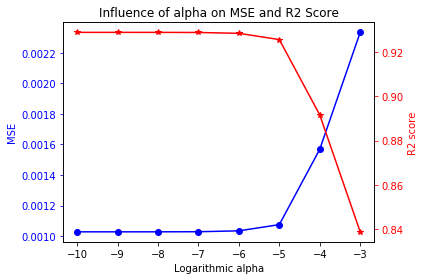

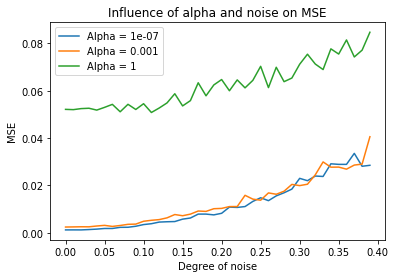

In [3]:
#from AnalysisFunctions import *
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.utils import resample

"""
    Analysis of a Lasso Regression model of Franke's function
"""

# Load data
X = np.load('data.npy')
x = X[:, 0]
y = X[:, 1]
z = FrankeFunction(x, y)

alphas = [10**-10, 10**-9, 10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3]
alpha_logs = [-10, -9, -8, -7, -6, -5, -4, -3]

Bs = []
for al in alphas:
    Bs.append(Lasso(x, y, z, degree=5, a=al))

# Generate new test data
x_test = np.random.rand(200)
y_test = np.random.rand(200)
z_test = FrankeFunction(x_test, y_test)

M_ = np.c_[x_test, y_test]
poly = PolynomialFeatures(5)
M = poly.fit_transform(M_)
MSEs = []
R2s = []
text_file = open("../Results/ex5/Bootstrap_lasso.txt", "w")
for i in range(len(alphas)):
    z_predict = M.dot(Bs[i])
    MSE = MeanSquaredError(z_test, z_predict)
    MSEs.append(MSE)
    R2_score = R2(z_test, z_predict)
    R2s.append(R2_score)
    text_file.write('--- Alpha value: {0} ---\n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(alphas[i], MSE, R2_score))

# make plot
fig, ax1 = plt.subplots()
ax1.plot(alpha_logs, MSEs, 'bo-')
ax1.set_xlabel('Logarithmic alpha')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('MSE', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(alpha_logs, R2s, 'r*-')
ax2.set_ylabel('R2 score', color='r')
ax2.tick_params('y', colors='r')

plt.title('Influence of alpha on MSE and R2 Score')
fig.tight_layout()
plt.savefig('../Results/ex5/MSE_R2_alpha.png')

# Investigate how the alpha values are influenced by noise
noise = np.arange(0, 0.4, 0.01)
alphas = [10**-7, 10**-3, 1]
Bs = []

# Generate more data to test
x_test = np.random.rand(200)
y_test = np.random.rand(200)
M_ = np.c_[x_test, y_test]
poly5 = PolynomialFeatures(5)
M = poly5.fit_transform(M_)

for al in alphas:
    B = []
    #print(al)
    for n in noise:
        z = FrankeFunction(x, y, noise=n)
        B.append(Lasso(x, y, z, degree=5, a=al))
    Bs.append(B)

lines = []
plt.figure()
for i in range(len(alphas)):
    text_file.write('--- alpha value: {} --- \n'.format(alphas[i]))
    line = []
    for j in range(len(noise)):
        z_test = FrankeFunction(x_test, y_test, noise=noise[j])
        z_predict = M.dot(Bs[i][j])
        MSE = MeanSquaredError(z_test, z_predict)
        line.append(MSE)
        R2_score = R2(z_test, z_predict)
        text_file.write(' Noise: {0} \n Mean Squared error: {1:.7f} \n R2 Score: {2:.7f}\n'.format(noise[j], MSE, R2_score))
    plt.plot(noise, line, label='Alpha = {0}'.format(alphas[i]))

plt.legend()
plt.xlabel('Degree of noise')
plt.ylabel('MSE')
plt.title('Influence of alpha and noise on MSE')
plt.savefig('../Results/ex5/alpha_noise_MSE.png')

MSE_l, R2_l, bias_l, variance_l = bootstrap(x, y, z, method='Lasso', p_degree=5)
text_file.write('--- BOOTSTRAP --- \n')
text_file.write('MSE: {} \n'.format(MSE_l))
text_file.write('R2: {} \n'.format(R2_l))
text_file.write('Bias: {} \n'.format(bias_l))
text_file.write('Variance: {} \n'.format(variance_l))

text_file.close()
